# BDT creation

In [1]:
from datetime import timedelta
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, kstwobign
import time

# the BDT framework I'll be using
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# helper functions to read in big data files
from read_h5_chunk import read_file_in_chunks
from mc_reader import MCReader

### Preparing data for BDT training

In [2]:
# get outkeys
all_keys = [
              ('ZTravel',       '<f8'),
              ('oneweight',     '<f8'),
              ('eff_oneweight', '<f8'),
              ('COGZ',          '<f8'),
              ('COGZSigma',     '<f8'),
              ('TrueEnergy',    '<f8'),
              ('TrueZenith',    '<f8'),
              ('TrueAzimuth',   '<f8'),
              ('PrimaryType',   '<f8'),
              ('RLogL',         '<f8'),
              ('RecoAzimuth',   '<f8'),
              ('RecoZenith',    '<f8'),
              ('QTot',          '<f8'),
              ('LDir_A',        '<f8'),
              ('NDirPulse_A',   '<f8'),
              ('NDirDOM_A',     '<f8'),
              ('NDirStr_A',     '<f8'),
              ('LDir_B',        '<f8'),
              ('NDirPulse_B',   '<f8'),
              ('NDirDOM_B',     '<f8'),
              ('NDirStr_B',     '<f8'),
              ('LDir_C',        '<f8'),
              ('NDirPulse_C',   '<f8'),
              ('NDirDOM_C',     '<f8'),
              ('NDirStr_C',     '<f8'),
              ('LDir_E',        '<f8'),
              ('NDirPulse_E',   '<f8'),
              ('NDirDOM_E',     '<f8'),
              ('NDirStr_E',     '<f8'),
              ('RecoAngSep',    '<f8'),
              ('BayesRatio',    '<f8')
             ]

dropkeys = ['oneweight', 'TrueEnergy', 'TrueZenith', 'TrueAzimuth', 'PrimaryType', 'RecoAzimuth', 
            'NDirDOM_C', 'NDirDOM_E', 'BayesRatio']

outkeys = [key for key, _ in all_keys if key not in dropkeys]
outkeys

['ZTravel',
 'eff_oneweight',
 'COGZ',
 'COGZSigma',
 'RLogL',
 'RecoZenith',
 'QTot',
 'LDir_A',
 'NDirPulse_A',
 'NDirDOM_A',
 'NDirStr_A',
 'LDir_B',
 'NDirPulse_B',
 'NDirDOM_B',
 'NDirStr_B',
 'LDir_C',
 'NDirPulse_C',
 'NDirStr_C',
 'LDir_E',
 'NDirPulse_E',
 'NDirStr_E',
 'RecoAngSep']

In [5]:
# macros
thin = 1000

In [6]:
# read in fluxes
conv_flux_nancy_path = '../../../jlazar/solar/data/mc_dn_dz/sibyll23c_conv_l3_b_nancy_merged_holeice-0300_2.npy'
solar_flux_nancy_path = '../../../jlazar/solar/data/mc_dn_dz/SIBYLL2.3_pp_HillasGaisser_H4a_l3_b_nancy_merged_holeice-0300_2.npy'
conv_flux_genie_path = '../../../jlazar/solar/data/mc_dn_dz/sibyll23c_conv_l3_b_genie_merged_holeice-0300_2.npy'
solar_flux_genie_path = '../../../jlazar/solar/data/mc_dn_dz/SIBYLL2.3_pp_HillasGaisser_H4a_l3_b_genie_merged_holeice-0300_2.npy'

conv_flux_nancy = np.load(conv_flux_nancy_path)[::thin]
solar_flux_nancy = np.load(solar_flux_nancy_path)[::thin]
conv_flux_genie = np.load(conv_flux_genie_path)[::thin]
solar_flux_genie = np.load(solar_flux_genie_path)[::thin]
print('done')

done


In [7]:
# load genie (3 min)
print('genie...')
genie_path = '../../../jlazar/big_files/solar_atmospherics/l3_b_genie_merged_holeice-0300_2.h5'
start_time = time.time()
genie = read_file_in_chunks(genie_path, outkeys, thin=thin)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

genie...
Finished in 0:08:30.864161


In [8]:
# load nancy (1.5 hrs)
print('nancy...')
nancy_path = '../../../jlazar/big_files/solar_atmospherics/l3_b_nancy_merged_holeice-0300_2.h5'
start_time = time.time()
nancy = read_file_in_chunks(nancy_path, outkeys, thin=thin)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

nancy...
Finished in 7:40:53.672080


In [9]:
# load corsika
print('corsika...')
corsika_path = '../../../jlazar/big_files/solar_atmospherics/l3_b_corsika_merged_holeice-0300_2.h5'
start_time = time.time()
corsika = read_file_in_chunks(corsika_path, outkeys, thin=thin)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

corsika...
Finished in 2:35:54.862891


In [10]:
# convert to particle-specific dataframes
solar_df = pd.concat([pd.DataFrame(nancy), pd.DataFrame(genie)])
conv_df = pd.concat([pd.DataFrame(nancy), pd.DataFrame(genie)])
muon_df = pd.DataFrame(corsika)

# total flux
solar_flux = np.concatenate([solar_flux_nancy, solar_flux_genie])
conv_flux = np.concatenate([conv_flux_nancy, conv_flux_genie])

# normalized rate information
muon_df['norm-rate'] = muon_df['eff_oneweight'].values / np.sum(muon_df['eff_oneweight'])
solar_df['norm-rate'] = solar_df['eff_oneweight'] * solar_flux / np.sum(solar_df['eff_oneweight']*solar_flux)
conv_df['norm-rate'] = conv_df['eff_oneweight'] * conv_flux / np.sum(conv_df['eff_oneweight']*conv_flux)

# add in solar atmospheric info
solar_df['solar'] = 1
conv_df['solar'] = 0
muon_df['solar'] = 0

# add in muon info
solar_df['muon'] = 0
conv_df['muon'] = 0
muon_df['muon'] = 1

In [11]:
# combine all dataframes
data = pd.concat([muon_df, solar_df, conv_df])
data = data.reset_index(drop=True)
data = data.drop(columns=['eff_oneweight'])

print(data.shape)
data.head(50)

(248461, 24)


,ZTravel,COGZ,COGZSigma,RLogL,RecoZenith,QTot,LDir_A,NDirPulse_A,NDirDOM_A,NDirStr_A,...,LDir_C,NDirPulse_C,NDirStr_C,LDir_E,NDirPulse_E,NDirStr_E,RecoAngSep,norm-rate,solar,muon
0,16.181664,195.756485,37.022224,33.874021,2.016922,9.025,NaN,1.0,1.0,1.0,...,111.748897,2.0,2.0,155.811024,9.0,2.0,0.000000,8.191633e-07,0,1
1,-7.344993,-484.685493,17.024304,12.109609,1.648250,16.400,2.616102,3.0,3.0,1.0,...,112.024518,9.0,3.0,217.910123,16.0,5.0,0.138682,1.882086e-06,0,1
2,30.808965,-468.372936,55.626224,10.777843,2.298335,14.050,NaN,1.0,1.0,1.0,...,105.305727,4.0,2.0,273.862977,14.0,7.0,0.000001,5.060057e-07,0,1
3,20.529619,-469.705253,38.928039,9.728152,1.333493,21.375,NaN,1.0,1.0,1.0,...,121.229243,3.0,2.0,475.207924,23.0,12.0,0.034508,9.895686e-08,0,1
4,54.926003,-410.891949,84.750390,12.444850,2.424589,11.275,NaN,1.0,1.0,1.0,...,262.574239,5.0,3.0,272.546712,13.0,4.0,0.011474,9.288141e-07,0,1
5,30.815002,-475.311019,28.586029,16.405692,1.644888,8.350,123.560334,2.0,2.0,2.0,...,123.560334,2.0,2.0,198.401885,8.0,4.0,0.002987,1.324057e-07,0,1
6,41.208185,-454.883928,39.626739,11.759983,2.605494,18.975,58.872780,3.0,3.0,1.0,...,73.505025,6.0,1.0,142.879712,21.0,4.0,0.040755,1.455363e-06,0,1
7,12.204276,-457.517310,35.244938,19.884675,2.177200,7.150,9.699980,2.0,2.0,1.0,...,19.798890,3.0,1.0,115.285965,8.0,3.0,0.168600,1.265474e-06,0,1
8,7.068383,-483.132749,24.225090,10.316551,2.348096,26.400,11.937094,4.0,2.0,1.0,...,23.712889,9.0,1.0,314.449718,30.0,8.0,0.226945,9.766535e-07,0,1
9,35.370000,-459.277373,33.388474,10.881262,1.816464,19.900,8.278653,4.0,2.0,1.0,...,117.934743,8.0,2.0,215.911207,24.0,6.0,0.073641,5.190191e-07,0,1


In [12]:
# number of nan entries
data.isna().sum()

ZTravel            0
COGZ               0
COGZSigma          0
RLogL              0
RecoZenith         0
QTot               0
LDir_A         84953
NDirPulse_A        0
NDirDOM_A          0
NDirStr_A          0
LDir_B         46577
NDirPulse_B        0
NDirDOM_B          0
NDirStr_B          0
LDir_C         22575
NDirPulse_C        0
NDirStr_C          0
LDir_E             0
NDirPulse_E        0
NDirStr_E          0
RecoAngSep       137
norm-rate          0
solar              0
muon               0
dtype: int64

In [13]:
# split into training and test sets (for muon BDT)
X, y_muon, y_solar = data.drop(columns=['solar', 'muon']), data['muon'], data['solar']
X_train, X_test, y_train, y_test = train_test_split(X, y_muon)
train_weights, test_weights = X_train['norm-rate'], X_test['norm-rate']
X_train, X_test = X_train.drop(columns=['norm-rate']), X_test.drop(columns='norm-rate')

### Performing cross-validation

In [19]:
# instantiate bdt
muBDT = HistGradientBoostingClassifier(max_iter=5000)

# setting up cross-validation
parameters = {'learning_rate': np.logspace(-5, 0, 10), # boosting parameter
              'max_leaf_nodes': np.arange(2, 62, 3),    # BDT complexity
              'l2_regularization': np.logspace(-3, 3, 7)} # regularization parameter
clf = GridSearchCV(muBDT, parameters, verbose=1)

# fitting
start_time = time.time()
clf.fit(X_train, y_train, sample_weight=train_weights)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


KeyboardInterrupt: 

In [18]:
train_weights

123808    5.545353e-06
70742     5.447626e-06
229359    1.288251e-06
183620    5.468915e-06
49799     4.436925e-06
73530     4.052765e-06
32504     5.666650e-06
127314    5.695740e-06
213337    3.602970e-05
235993    1.230983e-05
217252    1.810782e-05
60783     1.224920e-06
215845    2.528638e-05
22628     3.177442e-06
136346    5.709495e-06
106577    3.351323e-06
243839    5.200758e-08
225031    3.760681e-04
186532    3.893143e-06
59601     5.309492e-06
209119    2.874523e-05
26026     4.630617e-06
33497     5.640518e-06
21041     4.289624e-06
109870    6.758203e-06
34889     3.767725e-06
152001    4.258284e-06
46408     4.262471e-06
135154    4.631657e-06
25717     5.227184e-06
              ...     
165065    3.415647e-06
231242    4.812986e-06
106213    1.000699e-05
237261    5.015851e-05
67147     5.721686e-06
103728    4.878268e-06
111242    5.496774e-06
247152    2.835166e-08
18470     4.976288e-06
33359     4.539221e-06
101702    5.501885e-06
226568    2.242211e-06
245387    5

---

# First-pass BDT fitting

In [20]:
# instantiate bdt
muBDT = HistGradientBoostingClassifier(max_iter=5000, verbose=1)

# training
start_time = time.time()
muBDT.fit(X_train, y_train, train_weights)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

Binning 0.028 GB of training data: 0.765 s
Binning 0.003 GB of validation data: 0.276 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.61216, val loss: 0.61375, in 3.446s
[2/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.59330, val loss: 0.59676, in 3.551s
[3/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.57684, val loss: 0.58100, in 5.409s
[4/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.56247, val loss: 0.56730, in 4.815s
[5/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.54979, val loss: 0.55649, in 3.791s
[6/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.53881, val loss: 0.54646, in 4.053s
[7/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.52905, val loss: 0.53729, in 3.613s
[8/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.52058, val loss: 0.53042, in 3.353s
[9/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.51253, val loss: 0.52320, in 3.464s
[10/5000] 1 tree, 31 leaves, max depth = 8

[87/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.35638, val loss: 0.39046, in 3.444s
[88/5000] 1 tree, 31 leaves, max depth = 18, train loss: 0.35576, val loss: 0.39020, in 3.993s
[89/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.35520, val loss: 0.38998, in 3.781s
[90/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.35459, val loss: 0.38971, in 3.276s
[91/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.35406, val loss: 0.38979, in 3.168s
[92/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.35349, val loss: 0.38930, in 2.796s
[93/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.35285, val loss: 0.38863, in 2.501s
[94/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.35236, val loss: 0.38815, in 2.759s
[95/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.35176, val loss: 0.38797, in 2.740s
[96/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.35123, val loss: 0.38773, in 2.981s
[97/5000] 1 tree, 31 leaves, max depth = 10, train

[173/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32041, val loss: 0.37012, in 2.907s
[174/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32013, val loss: 0.36998, in 3.759s
[175/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.31991, val loss: 0.36981, in 4.199s
[176/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.31955, val loss: 0.36977, in 3.795s
[177/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.31921, val loss: 0.36948, in 3.974s
[178/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.31899, val loss: 0.36941, in 3.379s
[179/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.31875, val loss: 0.36930, in 3.332s
[180/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31845, val loss: 0.36916, in 3.218s
[181/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.31818, val loss: 0.36896, in 3.406s
[182/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.31794, val loss: 0.36880, in 3.810s
[183/5000] 1 tree, 31 leaves, max depth = 

[259/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.29881, val loss: 0.35926, in 3.101s
[260/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.29852, val loss: 0.35906, in 3.358s
[261/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.29830, val loss: 0.35896, in 4.454s
[262/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.29813, val loss: 0.35878, in 4.261s
[263/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.29796, val loss: 0.35864, in 3.629s
[264/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.29779, val loss: 0.35845, in 3.230s
[265/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.29762, val loss: 0.35834, in 4.435s
[266/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.29742, val loss: 0.35821, in 3.565s
[267/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.29728, val loss: 0.35816, in 3.163s
[268/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.29711, val loss: 0.35815, in 3.768s
[269/5000] 1 tree, 31 leaves, max depth =

[345/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.28185, val loss: 0.35084, in 4.366s
[346/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.28169, val loss: 0.35091, in 3.746s
[347/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.28153, val loss: 0.35081, in 3.750s
[348/5000] 1 tree, 31 leaves, max depth = 20, train loss: 0.28138, val loss: 0.35096, in 4.105s
[349/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.28120, val loss: 0.35082, in 3.669s
[350/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.28103, val loss: 0.35069, in 3.901s
[351/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.28088, val loss: 0.35062, in 4.392s
[352/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.28075, val loss: 0.35057, in 3.557s
[353/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.28054, val loss: 0.35060, in 3.568s
[354/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.28035, val loss: 0.35051, in 4.008s
[355/5000] 1 tree, 31 leaves, max depth =

[431/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.26880, val loss: 0.34540, in 4.076s
[432/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.26869, val loss: 0.34537, in 4.468s
[433/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.26853, val loss: 0.34545, in 3.822s
[434/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.26844, val loss: 0.34542, in 3.919s
[435/5000] 1 tree, 31 leaves, max depth = 19, train loss: 0.26833, val loss: 0.34536, in 4.439s
[436/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.26815, val loss: 0.34518, in 3.492s
[437/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.26797, val loss: 0.34512, in 3.555s
[438/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.26783, val loss: 0.34508, in 4.472s
[439/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.26770, val loss: 0.34501, in 4.077s
[440/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.26751, val loss: 0.34491, in 4.271s
[441/5000] 1 tree, 31 leaves, max depth 

[517/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.25691, val loss: 0.34059, in 3.944s
[518/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.25678, val loss: 0.34065, in 4.450s
[519/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.25664, val loss: 0.34054, in 4.176s
[520/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.25649, val loss: 0.34042, in 4.409s
[521/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.25634, val loss: 0.34042, in 4.640s
[522/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.25618, val loss: 0.34034, in 5.107s
[523/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.25605, val loss: 0.34023, in 4.676s
[524/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.25591, val loss: 0.34018, in 4.962s
[525/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.25576, val loss: 0.34002, in 5.226s
[526/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.25561, val loss: 0.33991, in 5.999s
[527/5000] 1 tree, 31 leaves, max depth 

[603/5000] 1 tree, 31 leaves, max depth = 19, train loss: 0.24616, val loss: 0.33728, in 3.425s
[604/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.24607, val loss: 0.33728, in 3.633s
[605/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.24594, val loss: 0.33721, in 3.612s
[606/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.24584, val loss: 0.33702, in 4.342s
[607/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.24575, val loss: 0.33702, in 4.370s
[608/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.24567, val loss: 0.33702, in 3.615s
[609/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.24557, val loss: 0.33695, in 3.721s
[610/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.24550, val loss: 0.33698, in 3.842s
[611/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.24538, val loss: 0.33689, in 3.141s
[612/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.24527, val loss: 0.33681, in 2.831s
[613/5000] 1 tree, 31 leaves, max depth 

[689/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.23717, val loss: 0.33376, in 4.212s
[690/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.23705, val loss: 0.33369, in 3.515s
[691/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.23692, val loss: 0.33374, in 4.282s
[692/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.23684, val loss: 0.33373, in 3.596s
[693/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.23674, val loss: 0.33381, in 3.502s
[694/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.23663, val loss: 0.33381, in 3.528s
[695/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.23653, val loss: 0.33398, in 3.189s
[696/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.23642, val loss: 0.33382, in 3.279s
[697/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.23628, val loss: 0.33387, in 3.008s
[698/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.23619, val loss: 0.33386, in 3.204s
[699/5000] 1 tree, 31 leaves, max depth =

[775/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.22877, val loss: 0.33152, in 3.356s
[776/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.22870, val loss: 0.33150, in 3.153s
[777/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.22859, val loss: 0.33144, in 3.372s
[778/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.22848, val loss: 0.33138, in 3.802s
[779/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.22840, val loss: 0.33139, in 3.726s
[780/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.22829, val loss: 0.33151, in 3.739s
[781/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.22821, val loss: 0.33158, in 3.694s
[782/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.22811, val loss: 0.33155, in 3.805s
[783/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.22800, val loss: 0.33151, in 3.990s
[784/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.22788, val loss: 0.33161, in 4.356s
[785/5000] 1 tree, 31 leaves, max depth 

In [21]:
# helper function to separate signal and background events
def sig_bkg_split(X, y, weights):
    '''
    Splits X and y into signal and background sets with weights
    
    Parameters
    ----------
    - X (DataFrame): features
    - y (DataFrame): signal indicator (1 if signal, 0 if background)
    - weights (DataFrame): weights of events
    
    Returns
    -------
    - X_sig, X_bkg, w_sig, w_bkg (dataFrame tuple): data organized according to signal/background status 
    '''
    # get signal and background mask
    sig_mask = y.loc[y.values==1].index
    bkg_mask = y.loc[y.values==0].index

    return X.loc[sig_mask], X.loc[bkg_mask], weights.loc[sig_mask], weights.loc[bkg_mask]

In [22]:
# get training and testing background/signal sets
train_sig, train_bkg, train_sig_weights, train_bkg_weights = sig_bkg_split(X_train, y_train, train_weights)
test_sig, test_bkg, test_sig_weights, test_bkg_weights = sig_bkg_split(X_test, y_test, test_weights)

In [23]:
# get predicted probabilities
train_sig_probs = muBDT.predict_proba(train_sig)[:, 1]
train_bkg_probs = muBDT.predict_proba(train_bkg)[:, 1]
test_sig_probs = muBDT.predict_proba(test_sig)[:, 1]
test_bkg_probs = muBDT.predict_proba(test_bkg)[:, 1]

In [108]:
# plotting probability scores
def gen_hist(axs, xlabel, scale, train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
             train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, decorate=True,
             *args, **kwargs):
    '''
    Plots signal probability histograms weighted according to weights.
    Parameters
    ----------
    - axs: list of matplotlib axes
        axes on which to plot
    - xlabel: str
        label for x-axis
    - scale: str 'lin' or 'log'
        scale for y-axis
    - train_sig_probs, ... test_bkg_probs: ndarrays
        BDT's predicted signal probability for each of train/test sig/bkg sets
    - train_sig_weights, ... test_bkg_weights: ndarrays
        weights associated with each train/test sig/bkg sets
    
    Returns
    -------
    - axs (matplotlib.pyplot.axes): axes with histogram attached
    '''

    # plot histograms
    axs[0].hist(train_sig_probs, weights=train_sig_weights, label='Muon samples', *args, **kwargs)
    axs[0].hist(train_bkg_probs, weights=train_bkg_weights, label='Neutrino samples', *args, **kwargs)
    if decorate:
        axs[0].set_title('Training sets')
        #axs[0].legend()
    
    axs[1].hist(test_sig_probs, weights=test_sig_weights, label='Muon samples', *args, **kwargs)
    axs[1].hist(test_bkg_probs, weights=test_bkg_weights, label='Neutrino samples', *args, **kwargs)
    if decorate:
        axs[1].set_title('Test sets')
        #axs[1].legend()
    
    # formatting
    axs[1].set_xlabel(xlabel)
    axs[0].set_yscale(scale)
    axs[1].set_yscale(scale)
    
    return axs

# plotting probability scores
def gen_hist_sing(ax, xlabel, scale, train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
             train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, decorate=True,
             *args, **kwargs):
    '''
    Plots signal probability histograms weighted according to weights.
    Parameters
    ----------
    - ax: matplotlib axes
        axes on which to plot
    - xlabel: str
        label for x-axis
    - scale: str 'lin' or 'log'
        scale for y-axis
    - train_sig_probs, ... test_bkg_probs: ndarrays
        BDT's predicted signal probability for each of train/test sig/bkg sets
    - train_sig_weights, ... test_bkg_weights: ndarrays
        weights associated with each train/test sig/bkg sets
    
    Returns
    -------
    - ax (matplotlib.pyplot.axes): axes with histogram attached
    '''
    
    ax.hist(test_sig_probs, weights=test_sig_weights, label='Muon samples', *args, **kwargs)
    ax.hist(test_bkg_probs, weights=test_bkg_weights, label='Neutrino samples', *args, **kwargs)
    # formatting
    ax.set_xlabel(xlabel)
    ax.set_yscale(scale)
    
    return ax

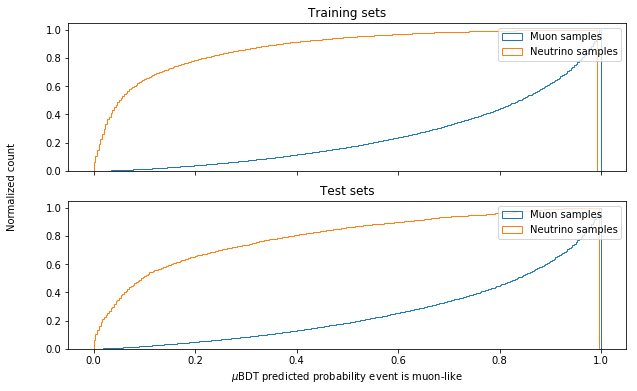

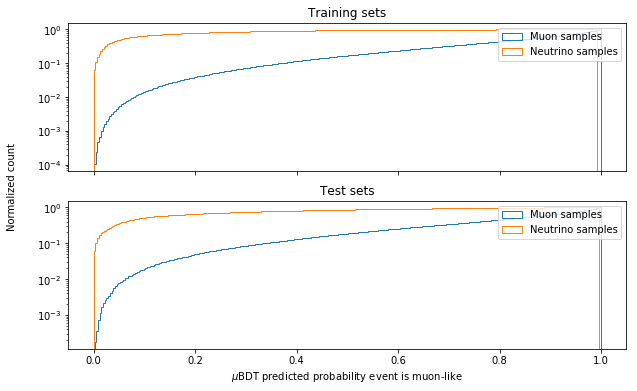

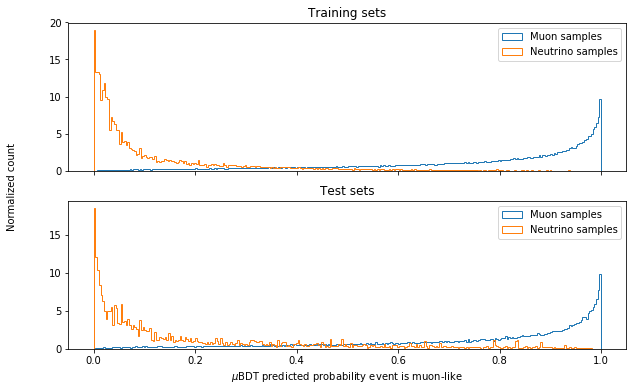

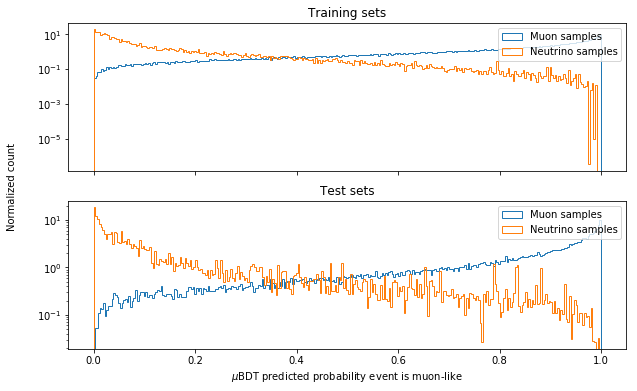

In [25]:
# plotting
for cum in [True, False]:
    for scale in ['linear', 'log']:
        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        axs = gen_hist(axs, '$\\mu$BDT predicted probability event is muon-like', scale,
                       train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
                       train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, 
                       bins=300, histtype='step', density=True, cumulative=cum)
        
        fig.text(0.04, 0.5, 'Normalized count', va='center', rotation='vertical')
        plt.show()

In [26]:
# helper function to compute results of two-sample Kolmogorov-Smirnov test
# see https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
def ks_test_weighted(data1, data2, wei1, wei2, alpha=0.05):
    # compute k-s test statistic
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    statistic = np.max(np.abs(cdf1we - cdf2we))
    
    # compute p-value
    pvalue = 1 - kstwobign.cdf(statistic)
    
    return statistic, pvalue

In [27]:
# report result of K-S test
ks_sig = ks_test_weighted(train_sig_probs, test_sig_probs, 
                          train_sig_weights.reset_index(drop=True).values, 
                          test_sig_weights.reset_index(drop=True).values)
ks_bkg = ks_test_weighted(train_bkg_probs, test_bkg_probs, 
                          train_bkg_weights.reset_index(drop=True).values, 
                          test_bkg_weights.reset_index(drop=True).values)

print('muon K-S test statistic, p-value:', ks_sig)
print('neutrino K-S test statistic, p-value:', ks_bkg)

muon K-S test statistic, p-value: (0.018228281178595707, 1.0)
neutrino K-S test statistic, p-value: (0.14579173042166982, 1.0)


/home/jvillarreal/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/jvillarreal/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


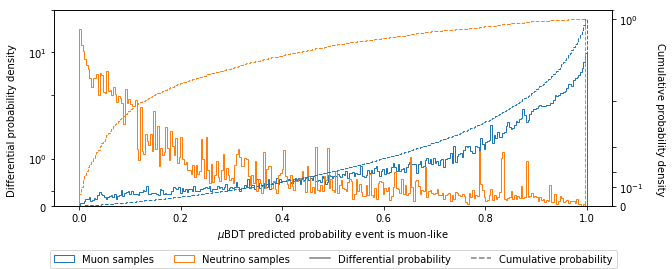

In [109]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# plotting differential distribution
ax = gen_hist_sing(ax, '$\\mu$BDT predicted probability event is muon-like', 'symlog',
               train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
               train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, 
               bins=300, histtype='step', density=True, cumulative=False)

# generate twin axes
ax_twin = ax.twinx()

# plotting cumulative distribution
ax_twin = gen_hist_sing(ax_twin, None, 'symlog', 
                    train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
                    train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, decorate=False,
                    bins=300, histtype='step', linestyle='dashed', density=True, cumulative=True)

# set yticks
ticks = np.concatenate(([0], np.logspace(-0.5, 1.5, 5)))
ax.set_yticks(ticks)
ticks = np.concatenate(([0], np.logspace(-1, 0, 5)))
ax_twin.set_yticks(ticks)
ax_twin.set_yticklabels(['0', '$10^{-1}$', '', '', '', '$10^0$'])

# axis labels
fig.text(0.06, 0.5, 'Differential probability density', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Cumulative probability density', va='center', rotation=270)

fig.subplots_adjust(bottom=0.2)

# manual legend
legend_elements = [Patch(facecolor='white', edgecolor='C0', label='Muon samples'),
                   Patch(facecolor='white', edgecolor='C1', label='Neutrino samples'),
                   Line2D([0], [0], color='gray', label='Differential probability'),
                   Line2D([0], [0], color='gray', linestyle='dashed', label='Cumulative probability')]

fig.legend(handles=legend_elements, ncol=4, loc=(0.075, 0.005))

plt.show()